# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

Here we are using the <B>German Traffic Sign Dataset</B> and creating a convolutional neural network based classifier to classify these signs.

The code below downloads the dataset. Convert the cell to "Code" to execute it.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.reset_default_graph()
# TODO: Fill this in based on where you saved the training and testing data
datafolder="data"
training_file = os.path.join(datafolder,"train.p")
validation_file=os.path.join(datafolder,"valid.p")
testing_file = os.path.join(datafolder,"test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

Using TensorFlow backend.


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Visualizations will be shown in the notebook.
%matplotlib inline

Let's load up the labels

In [4]:
import pandas as pd
rd=pd.read_csv("signnames.csv")
signs=list(rd["SignName"].values)

Now let's plot the distribution of samples across class

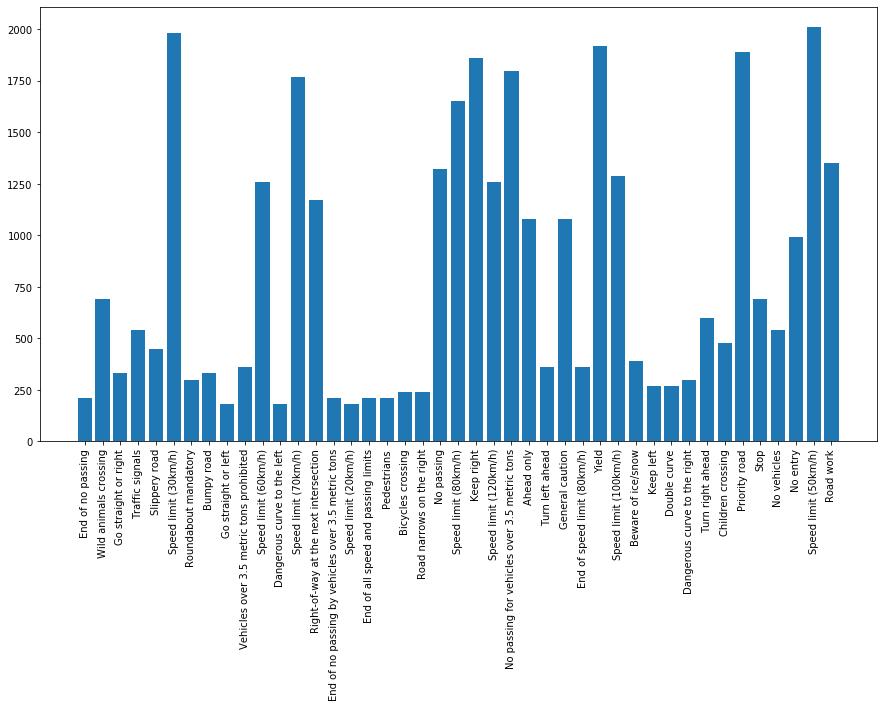

In [5]:
#visualize class distribution
from collections import Counter
cnt=Counter(y_train)
x_axis=[signs[i] for i in cnt.keys()]
y_axis=cnt.values()
fig=plt.figure(figsize=(15,8))
plt.bar(x_axis,y_axis)
plt.xticks(rotation='vertical')
plt.show()

The classes are quite imbalanced. Let's print the class information for classes having lowest and highest number of classes.

In [6]:
print("Class with highest number of samples:{0}({1})".format(signs[cnt.most_common()[0][0]],cnt.most_common()[0][1]))
print("Class with lowest number of samples:{0}({1})".format(signs[cnt.most_common()[-1][0]],cnt.most_common()[-1][1]))

Class with highest number of samples:Speed limit (50km/h)(2010)
Class with lowest number of samples:Speed limit (20km/h)(180)


Some random images from each of the classes

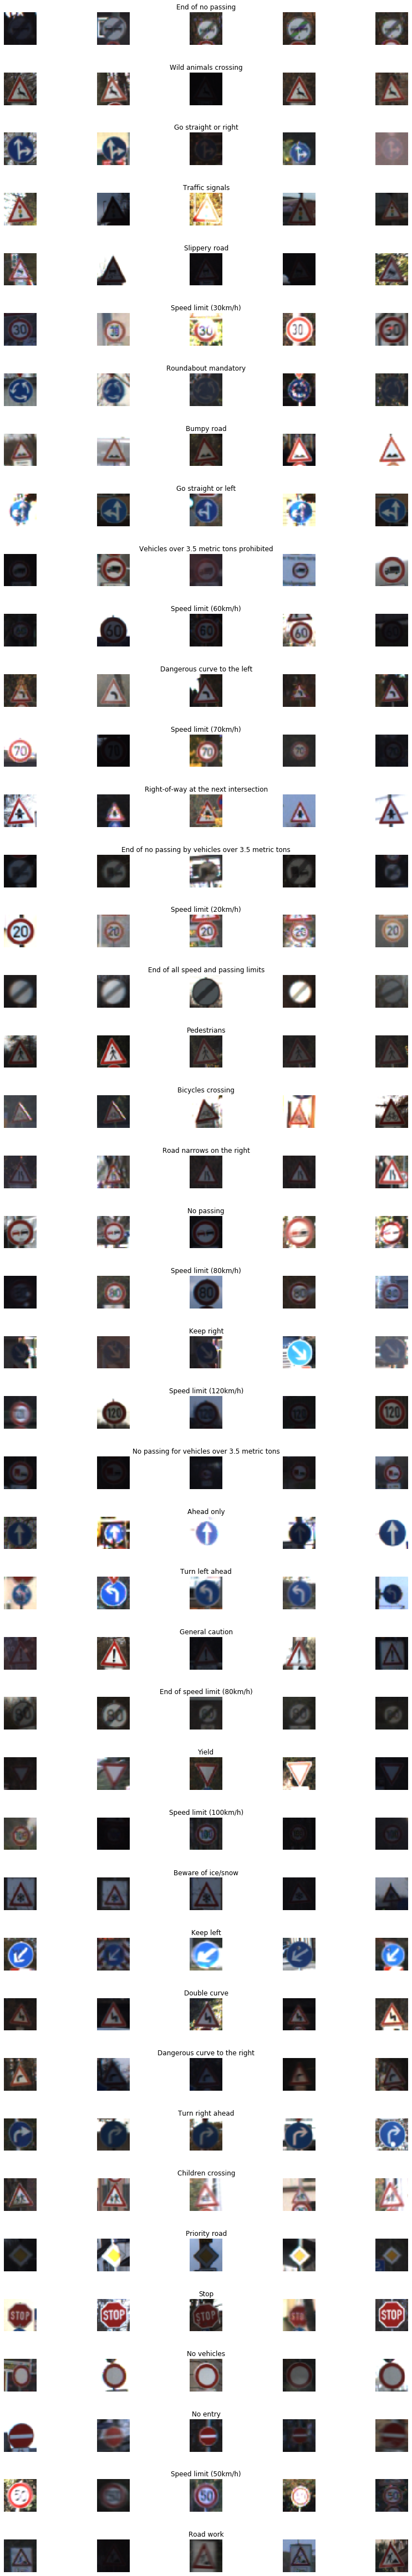

In [7]:
figure = plt.figure(figsize=(15,85))
spec = gridspec.GridSpec(ncols=5, nrows=len(cnt.keys()))
spec.update(wspace=0.005, hspace=0.85)
for i,cls in enumerate(cnt.keys()):
    index = np.where(y_train==cls)[0]
    index_rnd=random.sample(list(index),5)
    xt_samples=X_train[index_rnd]
    for j,sample in enumerate(xt_samples):
        ax = figure.add_subplot(spec[i,j])
        ax.imshow(sample)
        ax.set_axis_off()
        if j==2:
            ax.set_title(signs[cls])

Some interesting insights here. There are many images which are almost toot dark to see.It may cause issues.

### Pre-process the Data Set (normalization, grayscale, etc.)

For preprocessing, I decided to use the normalization technique suggested here. It should provide a mean close to 0 and variance close to 1. This helps with quick convergence and improves nonlinear response.
But it is not the case here. As many of the images have mean other than 128.
Experiments were done using both grayscale and rgb images. RGB images provided better accuracy so grayscaling was discarded at the end.

In [8]:
import cv2
from sklearn.utils import shuffle

def preprocess_data(img):
    img_f = img.astype(np.float32)
    return (img_f-128)/128
X_train = np.array([preprocess_data(img) for img in X_train])
X_valid = np.array([preprocess_data(img) for img in X_valid])
X_test = np.array([preprocess_data(img) for img in X_test])
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

For model architecture, initially LeNet 5 was chosen. Afterwards, various experiments were done on the architecture itself.
Finally the architecture that was found to be optimal is as follows:
1. Input Size (batch,32,32,3)
2. Conv2D(kernel 5x5, filters 16, stride 1, activation relu)
3. Maxpool2D(kernel 2x2, stride 2)
4. Conv2D(kernel 5x5, filters 32, stride 1, activation relu)
5. Maxpool2D(kernel 2x2, stride 2)
6. Flatten
7. Fullyconnected(output size 200)
8. Dropout(0.4)
9. Fullyconnected(output size 100)
10. logit(output size 43)


In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x,kp):    
    mu = 0
    sigma = 0.1
    # Store layers weight & bias
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 3 , 16],mean=mu,stddev=sigma)),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, 16, 32],mean=mu,stddev=sigma)),
        'wd1': tf.Variable(tf.truncated_normal([5*5*32, 200],mean=mu,stddev=sigma)),
        'wd2': tf.Variable(tf.truncated_normal([200, 100],mean=mu,stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([100, len(cnt.keys())],mean=mu,stddev=sigma))}

    biases = {
        'bc1': tf.Variable(tf.truncated_normal([16],mean=mu,stddev=sigma)),
        'bc2': tf.Variable(tf.truncated_normal([32],mean=mu,stddev=sigma)),
        'bd1': tf.Variable(tf.truncated_normal([200],mean=mu,stddev=sigma)),
        'bd2': tf.Variable(tf.truncated_normal([100],mean=mu,stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([len(cnt.keys())],mean=mu,stddev=sigma))}
    conv_layer_1 = tf.nn.conv2d(x,weights['wc1'],strides=[1,1,1,1],padding='VALID',name="first")
    conv_layer_1 = tf.nn.bias_add(conv_layer_1, biases['bc1'])
    conv_layer_1 = tf.nn.relu(conv_layer_1,name="conv_act_1")
    conv_layer_mp1 = tf.nn.max_pool(conv_layer_1,[1,2,2,1],[1,2,2,1],"VALID")
    conv_layer_2 = tf.nn.conv2d(conv_layer_mp1,weights['wc2'],strides=[1,1,1,1],padding='VALID')
    conv_layer_2 = tf.nn.bias_add(conv_layer_2, biases['bc2'])
    conv_layer_2 = tf.nn.relu(conv_layer_2,name="conv_act_2")
    conv_layer_mp2 = tf.nn.max_pool(conv_layer_2,[1,2,2,1],[1,2,2,1],"VALID")
    conv_layer_flt = flatten(conv_layer_mp2)
    conv_layer_fc1 = tf.add(tf.matmul(conv_layer_flt,weights['wd1']),biases['bd1'])
    conv_layer_fc1 = tf.nn.relu(conv_layer_fc1,name="fc_1")
    conv_layer_fc1 = tf.nn.dropout(conv_layer_fc1,rate=1-kp)
    conv_layer_fc2 = tf.add(tf.matmul(conv_layer_fc1,weights['wd2']),biases['bd2'])
    conv_layer_fc2 = tf.nn.relu(conv_layer_fc2,name="fc_2")
    logits = tf.add(tf.matmul(conv_layer_fc2,weights['out']),biases['out'], name="logits_out")
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Aside from standard X and Y variables, two other variables were kept as well.
1. Keep_prob: Dropout parameter
2. lr : Learning rate Placeholder

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3),name="input")
y = tf.placeholder(tf.int32, (None))
keep_prob=tf.placeholder(tf.float32,name="keep_prob")
lr = tf.placeholder(tf.float32,name="learning_rate")
one_hot_y = tf.one_hot(y, len(cnt.keys()))

For training, we used softmax crossentopy.
For Optimizer, Adam was used.
One thing to note here is dynamic learning rate.

In [30]:
rate = 0.001

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Training the model

In [13]:
EPOCHS = 20
BATCH_SIZE = 128
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.4, lr: rate})
        if i>0 and i%10==0:
            rate = rate*0.7
            print("Setting learning rate to",rate)
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.763
EPOCH 2 ...
Validation Accuracy = 0.899
EPOCH 3 ...
Validation Accuracy = 0.925
EPOCH 4 ...
Validation Accuracy = 0.941
EPOCH 5 ...
Validation Accuracy = 0.948
EPOCH 6 ...
Validation Accuracy = 0.955
EPOCH 7 ...
Validation Accuracy = 0.954
EPOCH 8 ...
Validation Accuracy = 0.961
EPOCH 9 ...
Validation Accuracy = 0.960
EPOCH 10 ...
Validation Accuracy = 0.966
Setting learning rate to 0.0007
EPOCH 11 ...
Validation Accuracy = 0.959
EPOCH 12 ...
Validation Accuracy = 0.967
EPOCH 13 ...
Validation Accuracy = 0.962
EPOCH 14 ...
Validation Accuracy = 0.966
EPOCH 15 ...
Validation Accuracy = 0.963
EPOCH 16 ...
Validation Accuracy = 0.967
EPOCH 17 ...
Validation Accuracy = 0.961
EPOCH 18 ...
Validation Accuracy = 0.963
EPOCH 19 ...
Validation Accuracy = 0.968
EPOCH 20 ...
Validation Accuracy = 0.963
Model saved


## Evaluate on test dataset

In [14]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.951


---

## Test model on New Images

To test the model on new images, some images were downloaded. Now google searching shows images either related to various tutorials regarding this very problem or from commercial copyrighted image purchasing sites. So, I decided to download my images from Wikipedia (https://en.wikipedia.org/wiki/Road_signs_in_Germany).

### Load and Output the Images

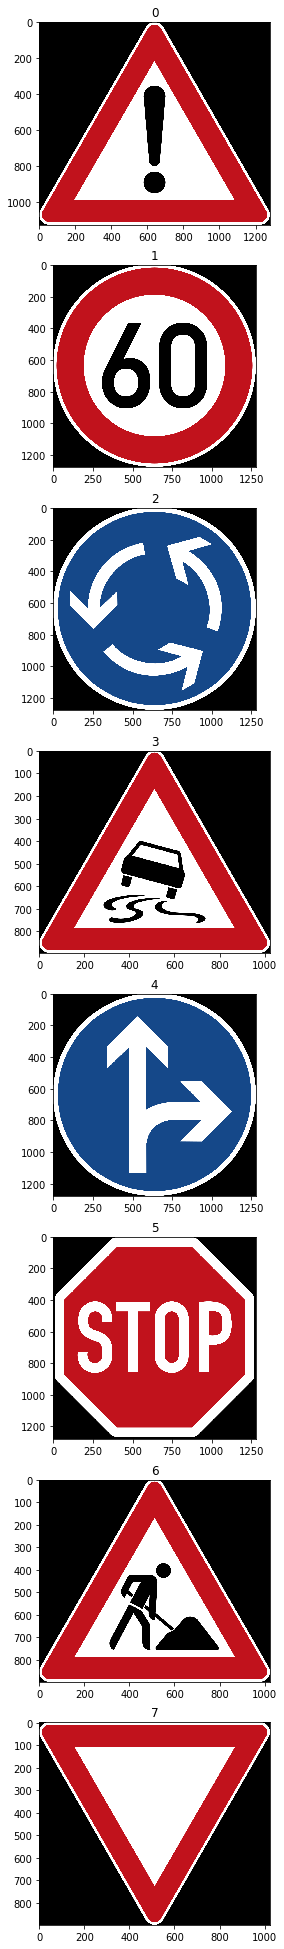

In [22]:
list_web_img=os.listdir("test_images/")
img_arr=[]
fig, ax = plt.subplots(len(list_web_img),figsize=(15,35))
for i,image_file in enumerate(list_web_img):
    imgpath=os.path.join("test_images",image_file)
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img_p = cv2.resize(img,(32,32))
    img_p = preprocess_data(img_p)
    #img_p_r=np.reshape(img_p,img_p.shape+(1,))
    img_arr.append(img_p)
    ax[i].imshow(img)
    ax[i].set_title(i)

### Predict the Sign Type for Each Image

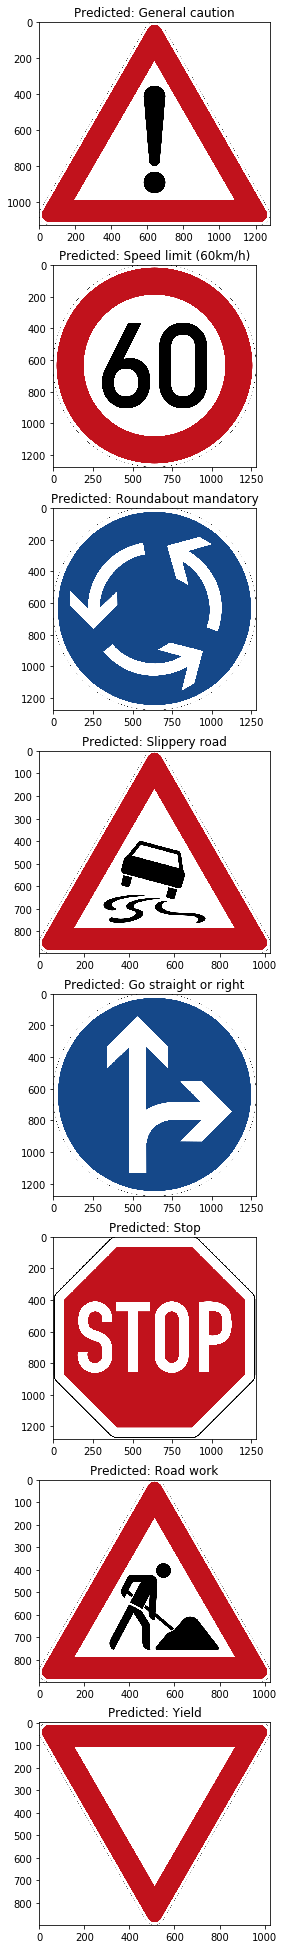

In [23]:
#tf.reset_default_graph()
prediction_softmax_items=[]
fig, ax = plt.subplots(len(list_web_img),figsize=(15,35))
#sess_predict=tf.Session()
#sess_predict.run(tf.global_variables_initializer())
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

#new_saver = tf.train.import_meta_graph('lenet.meta')
#new_saver.restore(sess_predict, tf.train.latest_checkpoint('./'))
    idx=0
    for img_disp,img_feed_arr in zip(list_web_img, img_arr):
        img_feed = img_feed_arr.reshape((1,32,32,3))
        predictions = sess.run(logits, feed_dict={x: img_feed,keep_prob:1})
        pred_softmax=sess.run(tf.nn.softmax(predictions[0]))
        prediction_softmax_items.append(sess.run(tf.nn.top_k(tf.constant(pred_softmax), k=5)))
        pred_idx=sess.run(tf.argmax(pred_softmax))
        #print(pred_idx,signs[pred_idx])
        img_d=plt.imread(os.path.join("test_images",img_disp))
        ax[idx].imshow(img_d)
        ax[idx].set_title("Predicted: {0}".format(signs[pred_idx]))
        idx+=1

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [24]:
for k,sm in enumerate(prediction_softmax_items):
    print("For image",k," ",end="")
    for i in range(len(sm.values)):
        prob=sm.values[i]
        cls=signs[sm.indices[i]]
        print("{0}({1}) ".format(cls,prob),end="")
        if i==len(sm.values)-1:
            print()
            print()

For image 0  General caution(1.0) Pedestrians(1.8579429754349998e-20) Traffic signals(2.565706196498018e-23) Right-of-way at the next intersection(7.794090573515415e-26) Children crossing(5.716849711935802e-26) 

For image 1  Speed limit (60km/h)(0.9785960912704468) Go straight or right(0.01737941987812519) Children crossing(0.002721489407122135) Speed limit (30km/h)(0.0010356141719967127) End of speed limit (80km/h)(0.00016340595902875066) 

For image 2  Roundabout mandatory(1.0) Keep right(2.849174021712919e-12) Right-of-way at the next intersection(8.758255622479116e-14) Go straight or left(1.6929178260518922e-14) Turn left ahead(4.755016808088725e-15) 

For image 3  Slippery road(1.0) Speed limit (60km/h)(2.122037126163598e-15) Wild animals crossing(6.792473733101028e-19) No passing for vehicles over 3.5 metric tons(9.049973232320113e-24) Beware of ice/snow(3.513743750997365e-25) 

For image 4  Go straight or right(1.0) Turn left ahead(1.9972593457567855e-12) Roundabout mandatory(1

One thing is evident that for most of the images here, the model is quite strongly confident about it's decisions. as seen from the output above, Here is the max probability for each of the images.
<table>
<tr><th>Probability</th><th>Prediction</th></tr>
<tr><td>1.0</td><td>General Caution</td></tr>
<tr><td>0.98</td><td>Speed Limit(60km/h)</td></tr>
<tr><td>1.0</td><td>Roundabout Mandatory</td></tr>
<tr><td>1.0</td><td>Slippery Road</td></tr>
<tr><td>1.0</td><td>Go straight or right</td></tr>
<tr><td>0.75</td><td>Stop</td></tr>
<tr><td>1.0</td><td>Road Work</td></tr>
<tr><td>1.0</td><td>Yield</td></tr>    
</table>

## Visualize the Neural Network's State with Test Images

In [27]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1,sess=sess):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input,keep_prob:1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

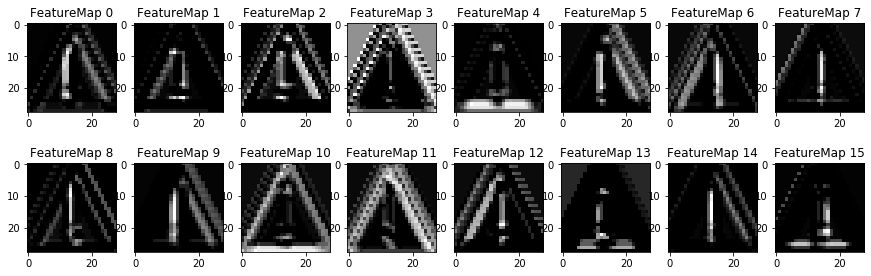

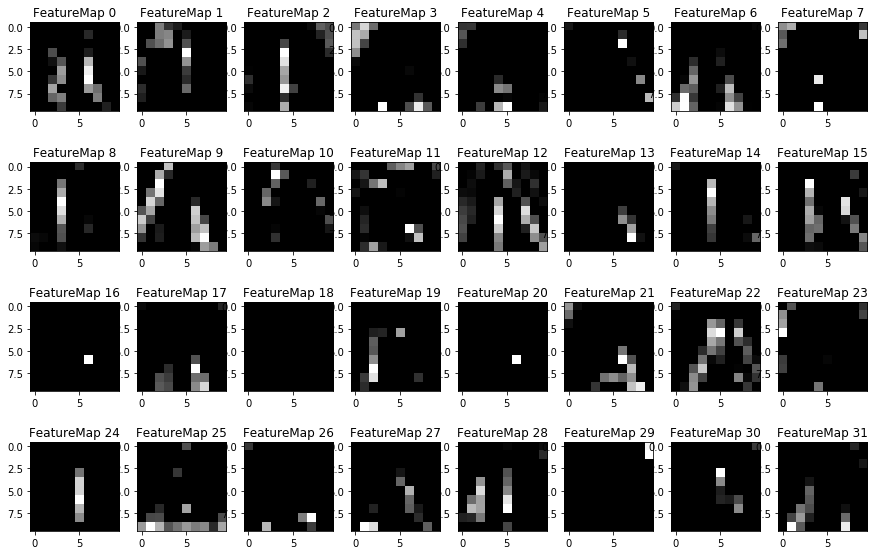

In [29]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    outputFeatureMap(img_arr[0].reshape(1,32,32,3),tf.get_default_graph().get_tensor_by_name("conv_act_1:0"),plt_num=1,sess=sess)
    outputFeatureMap(img_arr[0].reshape(1,32,32,3),tf.get_default_graph().get_tensor_by_name("conv_act_2:0"),plt_num=2,sess=sess)

Here we are visualizing feature maps for our first test image.It seems here the sign was detected based on edge. First feature maps show activation on exclamation mark and triangular edges. Second feature map shows that the network is focussing on the triangular shapes and exclamation mark and it has discarded almost any other features.